In [57]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from random import randint
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

In [80]:
train_input , train_target = bci.load ( root = "./ data_bci")
test_input , test_target = bci.load ( root = "./ data_bci " , train = False )

train_target = Variable(train_target)
train_input = Variable(train_input.unsqueeze(dim=2))
test_input = Variable(test_input.unsqueeze(dim=2))
test_target = Variable(test_target)

mu, std = train_input.data.mean(), train_input.data.std() 
train_input.data.sub_(mu).div_(std)
test_input.data.sub_(mu).div_(std)


print('train_input size:' , train_input.size())
print ( 'train_target size:' , train_target.size())
print ('test_input size:' , test_input.size())
print ('test_target size:' , test_target.size())

train_input size: torch.Size([316, 28, 1, 50])
train_target size: torch.Size([316])
test_input size: torch.Size([100, 28, 1, 50])
test_target size: torch.Size([100])


In [81]:
# The function computes the accuracy
def accuracy(output,target):
    return (output.float()==target.float()).float().sum()/len(output)

## Convolutional neural network

In [91]:

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d (28, 32, kernel_size = (1,5))    # after conv: 20*32*1*46
        self.avg_pool1 = nn.AvgPool2d(kernel_size = (1,4))      # size -> 1/4 *size
        self.conv2 = nn.Conv2d (32 , 64, kernel_size = (1,5))   
        self.fc1 = nn.Linear (448 , 50)                         # size : 64 ->32 => 448/2
        self.dr = nn.Dropout(p=0.8)
        self.fc2 = nn.Linear (50 , 2)
        
    def forward (self , x):
        x = self.conv1(x)
        #print ('after first conv',x.size())
        x = F.relu(self.avg_pool1(x))
        x = F.relu(self.conv2(x))
        x = x.view (-1, 448)
        x = self.dr(x)
        x = F.relu ( self.fc1 (x))
        x = self.dr(x)
        x = self.fc2(x)
                   #x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 3, stride =3) )
        #x = F.relu (F.max_pool2d ( self.conv2(x), kernel_size =2, stride =2) )
        return x


In [90]:
### train the model
epoch = 10
batch_size = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.5)



i = 0
for e in range(epoch):
    for b in range(0,train_input.size(0),batch_size):
        input_ = train_input.narrow(0,b,min(batch_size,train_input.size(0)-b))
        target = train_target.narrow(0,b,min(batch_size,train_input.size(0)-b))
        output = net(input_).view(min(batch_size,train_input.size(0)-b),2)
        loss = criterion(output,target)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%100 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print(e//100,'loss train:',criterion(output_train,train_target).data[0],'loss test:',criterion(output,test_target).data[0],' accuracy test:',accuracy(predicted_class,test_target).data[0])

0 loss train: 0.02089495025575161 loss test: 1.3512645959854126  accuracy test: 0.7799999713897705


## Data Augmentaiotn: Averaging two datapoints in the same class

In [73]:
class0 = train_input[(train_target == 0).nonzero(),]
class1 = train_input[(train_target == 1).nonzero(),]
class0.squeeze_(dim=1)
class1.squeeze_(dim=1)
N = class0.shape[0]
train_input_aug0 = [(class0[i]+class0[j])/2 for i in range(N) for j in range(i,N)]
train_input_aug0 = torch.stack(train_input_aug0)
train_out_aug0 = Variable(Tensor(train_input_aug0.shape[0]).fill_(0))
N = class1.shape[0]
train_input_aug1 = [(class1[i]+class1[j])/2 for i in range(N) for j in range(i,N)]
train_input_aug1 = torch.stack(train_input_aug1)
train_out_aug1 = Variable(Tensor(train_input_aug1.shape[0]).fill_(1))

###
train_aug = torch.cat((train_input_aug0,train_input_aug1))
train_target_aug = torch.cat((train_out_aug0,train_out_aug1)).data.long()

mu, std = train_aug.data.mean(), train_aug.data.std() ;
train_aug.data.sub_(mu).div_(std);
test_input.data.sub_(mu).div_(std);

In [74]:
class Dataset:
    def __init__(self,train_aug,train_target):
        self.train_aug = train_aug.data
        self.train_target = train_target
    def __getitem__(self, index):
        return self.train_aug[index], self.train_target[index]
    def __len__(self):
        return len(self.train_target)

In [75]:
data = Dataset(train_aug,train_target_aug)
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size = 40, shuffle=True,
                                             num_workers=4)

In [100]:

net = Net()

In [106]:

### train the model
epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.5)
i = 0
for e in range(epoch):
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_) 
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print(e//1,'loss train:',criterion(output_train,train_target).data[0],'loss test:',criterion(output,test_target).data[0],' accuracy test:',accuracy(predicted_class,test_target).data[0])

0 loss train: 0.6952154636383057 loss test: 0.6886308193206787  accuracy test: 0.5699999928474426
1 loss train: 0.6738304495811462 loss test: 0.6873528957366943  accuracy test: 0.6800000071525574
2 loss train: 0.5158264636993408 loss test: 0.7171140313148499  accuracy test: 0.7400000095367432
3 loss train: 0.42435938119888306 loss test: 0.8130353689193726  accuracy test: 0.7200000286102295
4 loss train: 0.677112340927124 loss test: 1.4532579183578491  accuracy test: 0.6299999952316284
5 loss train: 0.5639277100563049 loss test: 0.8481715321540833  accuracy test: 0.7200000286102295
6 loss train: 0.2967013418674469 loss test: 0.8411137461662292  accuracy test: 0.7699999809265137
7 loss train: 0.34494131803512573 loss test: 0.7394730448722839  accuracy test: 0.7900000214576721
8 loss train: 0.3075798749923706 loss test: 1.0522758960723877  accuracy test: 0.7799999713897705
9 loss train: 0.27261701226234436 loss test: 0.8978402614593506  accuracy test: 0.7099999785423279


## Adding L1 reguralizer

In [115]:
def l1_reguralizer(paramters):
    loss = 0
    for p in paramters:
        loss += torch.abs(p).mean()
    return loss

In [149]:
net = Net()

In [150]:

### train the model
epoch = 100
lambda_ = 10**-2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.5)
i = 0
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []
for e in range(epoch):
    if e == 30:
        optimizer = optim.SGD(net.parameters(),lr = 0.003,momentum = 0.5)
    if e== 60:
        optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.5)
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_) + lambda_ * l1_reguralizer(net.parameters())
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output_train.max(dim=1)
        accuracy_train.append(accuracy(predicted_class_train,train_target).data[0])
        accuracy_test.append(accuracy(predicted_class,test_target).data[0])
        loss_train.append(criterion(output_train,train_target).data[0]+ lambda_ * l1_reguralizer(net.parameters()).data[0])
        loss_test.append(criterion(output,test_target).data[0]+ lambda_ * l1_reguralizer(net.parameters()).data[0])
        print(e//1,'loss train:',round(loss_train[-1],2), 'accuracy train:', round(accuracy_train[-1],2),\
              'loss test:',round(loss_test[-1],2),' accuracy test:',round(accuracy_test[-1],2))

0 loss train: 0.69 accuracy train: 0.53 loss test: 0.71  accuracy test: 0.53
1 loss train: 0.67 accuracy train: 0.61 loss test: 0.86  accuracy test: 0.55
2 loss train: 0.6 accuracy train: 0.7 loss test: 0.76  accuracy test: 0.64
3 loss train: 0.45 accuracy train: 0.78 loss test: 0.56  accuracy test: 0.78
4 loss train: 0.52 accuracy train: 0.78 loss test: 1.02  accuracy test: 0.69
5 loss train: 0.39 accuracy train: 0.82 loss test: 0.74  accuracy test: 0.72
6 loss train: 0.32 accuracy train: 0.85 loss test: 0.91  accuracy test: 0.75
7 loss train: 0.79 accuracy train: 0.74 loss test: 0.89  accuracy test: 0.74
8 loss train: 0.37 accuracy train: 0.9 loss test: 0.85  accuracy test: 0.77
9 loss train: 0.33 accuracy train: 0.88 loss test: 0.81  accuracy test: 0.78
10 loss train: 0.68 accuracy train: 0.79 loss test: 1.6  accuracy test: 0.66
11 loss train: 0.21 accuracy train: 0.9 loss test: 0.9  accuracy test: 0.76
12 loss train: 0.25 accuracy train: 0.9 loss test: 0.79  accuracy test: 0.81
13 

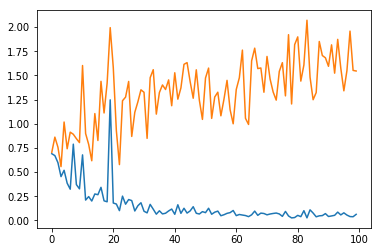

In [152]:
plt.plot(loss_train)
plt.plot(loss_test)

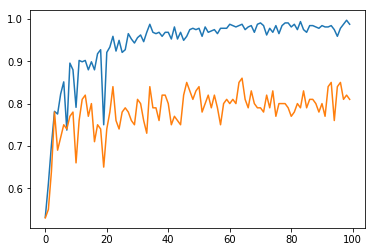

In [154]:
plt.plot(accuracy_train)
plt.plot(accuracy_test)

## Average between 3

In [59]:
class0 = train_input[(train_target == 0).nonzero(),]
class1 = train_input[(train_target == 1).nonzero(),]
class0.squeeze_(dim=1)
class1.squeeze_(dim=1)

N = class0.shape[0]
train_input_aug0 = [(class0[randint(0,N-1)]+class0[randint(0,N-1)]+ class0[randint(0,N-1)])/3 for i in range(200*10**3)]
train_input_aug0 = torch.stack(train_input_aug0)
train_out_aug0 = Variable(Tensor(train_input_aug0.shape[0]).fill_(0))
N = class1.shape[0]
train_input_aug1 = [(class0[randint(0,N-1)]+class0[randint(0,N-1)]+ class0[randint(0,N-1)])/3 for i in range(200*10**3)]
train_input_aug1 = torch.stack(train_input_aug1)
train_out_aug1 = Variable(Tensor(train_input_aug1.shape[0]).fill_(1))

###
train_aug = torch.cat((train_input_aug0,train_input_aug1))
train_target_aug = torch.cat((train_out_aug0,train_out_aug1)).data.long()

In [61]:
data = Dataset(train_aug,train_target_aug)
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size = 100, shuffle=True,
                                             num_workers=4)

In [62]:
net = Net()

In [70]:
### train the model
epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.0001,momentum = 0.5)
i = 0
for e in range(epoch):
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print(e//1,'loss train:',criterion(output_train,train_target).data[0],'loss test:',criterion(output,test_target).data[0],' accuracy test:',accuracy(predicted_class,test_target).data[0])

0 loss train: 0.972797155380249 loss test: 1.0354115962982178  accuracy test: 0.47999998927116394
1 loss train: 0.9761149883270264 loss test: 1.1677064895629883  accuracy test: 0.5099999904632568
2 loss train: 0.9124852418899536 loss test: 0.981426477432251  accuracy test: 0.49000000953674316
3 loss train: 0.9623199701309204 loss test: 1.0508921146392822  accuracy test: 0.47999998927116394
4 loss train: 0.9801075458526611 loss test: 1.0371037721633911  accuracy test: 0.47999998927116394
5 loss train: 0.9583073854446411 loss test: 1.1277952194213867  accuracy test: 0.5099999904632568
6 loss train: 0.9784257411956787 loss test: 1.0535842180252075  accuracy test: 0.46000000834465027
7 loss train: 0.9714837670326233 loss test: 1.118096947669983  accuracy test: 0.44999998807907104
8 loss train: 0.9817187190055847 loss test: 1.2405074834823608  accuracy test: 0.5199999809265137
9 loss train: 0.9704495072364807 loss test: 1.1885745525360107  accuracy test: 0.5099999904632568
